<a href="https://colab.research.google.com/github/ronitagarwala01/NASA_GCN_ML/blob/main/InformationExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Information Extraction Model for NASA GCN Project**
The goal of this project is to extract important information from NASA GCN Circulars for the purpose of automated data entry into the archive, which is currently done manually.

#Step 1: Import Libraries

In [ ]:
'''
Author: Ronit Agarwala
Last Modified: 09/12/2023
'''

import pandas as pd
import tarfile
import os
import re
import csv
import torch

#Step 2: Extract Data

In [ ]:
'''
Extract table data from csv file.
This will contain our labels for the model.
'''

df = pd.read_csv('swift_redshift_data.csv', skiprows=0, header=0)
print(df)

         GRB  Time[UT] TriggerNumber        BAT RA(J2000)  \
0    230818A  23:27:34       1186032  285.888\n19:03:33.1   
1    230506C  17:09:19       1167288  134.371\n08:57:29.0   
2    230414B  16:14:21       1164180  181.052\n12:04:12.5   
3    230328B  14:54:48       1162001  291.037\n19:24:08.9   
4    230325A  03:15:35       1161390  296.854\n19:47:25.0   
..       ...       ...           ...                  ...   
415   050319  09:31:18        111622  154.172\n10:16:41.3   
416   050318  15:44:37        111529   49.695\n03:18:46.8   
417   050315  20:59:43        111063  306.476\n20:25:54.2   
418   050223  03:09:06        106709  271.394\n18:05:34.6   
419   050126  12:00:54        103780  278.115\n18:32:27.6   

           BAT Dec(J2000) BAT T90[sec]  BAT Fluence(15-150 keV)[10-7 erg/cm2]  \
0      40.888\n40:53:16.8         9.82                                  19.00   
1      45.131\n45:07:51.6        31.00                                  17.00   
2      53.179\n53:10:44.

In [ ]:
'''
Extract GCN Circulars from .tar.gz file to a new unzipped folder.
Store the path for each circular in the unzipped folder in list 'dir'.
'''

file = tarfile.open('./all_gcn_circulars.tar.gz')
file.extractall('./all_gcn_circulars')
file.close()

dir = os.listdir('./all_gcn_circulars/gcn3') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
for i in range(len(dir)):
  dir[i] = './all_gcn_circulars/gcn3/' + dir[i]

print(f"Number of circulars: {len(dir)}")
print(f"First circular path: {dir[0]}")

Number of circulars: 33653
First circular path: ./all_gcn_circulars/gcn3/mistake34.txt


In [ ]:
'''
Iterate through each path in dir, and store the text in lower case.
This will contain our features for the model.
'''

circulars = [] #List to store the text of each GCN
full_text = '' #String to store entire corpus of data
for gcn in dir:
  with open(gcn, encoding = "ISO-8859-1") as f:
    file_str = f.read().lower()
    circulars.append(file_str)
    full_text += file_str

print(circulars[0]) #Print first circular

circular 20213 was mistakenly submitted by an errant demon. 
it has been removed from the archive listing.

gcn ops note(29nov2016) per author's request 20213 was removed from the archive.



In [ ]:
redshift_circulars = []
for circular in circulars:
  if "redshift" in circular:
    redshift_circulars.append(circular)

print(redshift_circulars[0])

title:   gcn circular
number:  11638
subject: grb 110205a: fast redshift
date:    11/02/05 07:57:29 gmt
from:    s. bradley cenko at caltech  <cenko@srl.caltech.edu>

s. b. cenko (uc berkeley), j. l. hora (cfa), and j. s. bloom (uc berkeley)
report on behalf of a larger collaboration:

we obtained a pair of spectra of the optical afterglow of grb 110205a
(beardmore et al., gcn 11629) with the fast spectrograph mounted on the
flwo 1.5 m telescope.  observations began at 6:27 ut (~ 4.5 hours after
the burst) and cover the wavelength range from 3500-7400 a.

as reported by da silva et al (gcn 11635), the spectrum exhibits a
prominent dla absorption feature; however, we observe this feature at a
slightly larger wavelength (~ 3900 a).  we further identify a series of
narrow absorption features, including si ii, si ii*, c iv, and al ii, at a   
common redshift of z=2.22.  the detection of si ii*, together with the dla
system, strongly suggest this is the host galaxy of grb 110205a.




In [ ]:
print(len(redshift_circulars))

2248


In [ ]:
'''
Get smaller dataframe with relevant information only.
This section converts the SWIFT GRB Table to a python dict.
The end result is a dict with key = GCN No. and value = Redshift Text.
'''

sub_df = df[['References', 'Redshift', 'GRB']].copy()
removed_list = []
removed_indices=[]
gcn_format = re.compile('GCN ?\d+( *\(.*?\))?')
gcn_number_format = re.compile('GCN ?(\d+)')
bracket_format = re.compile(' ?\([^)]*\)')
instrument_format = re.compile('\((.*?)\)')
instrument_format_1 = re.compile('\(([^):]*)')

#Extract just the Redshift References from the References column
for index, row in sub_df.iterrows():
  row['References'] = row['References'].splitlines()
  row['Redshift'] = row['Redshift'].splitlines()

  temp=''
  for line in row['References']: #Extract only redshift references
    if line[0:8] == 'Redshift':
      temp = line
  if temp != '':
    row['References'] = temp

  if isinstance(row['References'], list): #Drop the non-uniform data for now
    removed_list.append((row['References'], row['Redshift'], row['GRB']))
    removed_indices.append(index)

red_list = [] #List of tuples
sub_df = sub_df.drop(removed_indices)

#Create a list of tuples
#Each tuple contains a GCN No. with it's corresponding Redshift Text and GRB Name
for index, row in sub_df.iterrows():
  gcn_iter = gcn_format.finditer(row['References'])
  gcns = list(gcn_iter)

  #References with only one circular don't need any further iteration
  if len(gcns) == 1 and len(row['Redshift']) == 1:
    gcn_num_match = gcn_number_format.search(gcns[0].group())

    instrument_match = instrument_format.search(gcns[0].group())
    instrument_match_1 = instrument_format_1.search(row['Redshift'][0])
    instrument_name = ''
    if instrument_match == None and instrument_match_1 == None: #Drop references with no instrument name for now
      removed_list.append((row['References'], row['Redshift'], row['GRB']))
      continue

    elif instrument_match != None:
      instrument_name = instrument_match.group(1)

    elif instrument_match_1 != None:
      instrument_name = instrument_match_1.group(1)

    gcn_num = gcn_num_match.group(1)
    redshift_text = bracket_format.sub('', row['Redshift'][0])
    grb_name = row['GRB']

    if len(redshift_text.split(',')) != 1: #Drop the non-uniform data for now
      removed_list.append((row['References'], row['Redshift'], row['GRB']))
      continue

    red_list.append((gcn_num, redshift_text.strip().lower(), grb_name.strip().lower(), instrument_name.strip().lower()))

  #If multiple circulars are present, iterate through them all
  else:
    for gcn in gcns:
      for redshift in row['Redshift']:

        #Extract instrument name from reference
        instrument_match = instrument_format.search(gcn.group())
        if instrument_match == None:
          continue
        instrument_name = instrument_match.group(1)

        #Extract instrument name from redshift text
        instrument_match_1 = instrument_format_1.search(redshift)
        if instrument_match_1 == None:
          continue
        instrument_name_1 = instrument_match_1.group(1)

        #Check to see if both instruments match. If yes, append tuple to list
        if instrument_name == instrument_name_1:
          gcn_num_match = gcn_number_format.search(gcn.group())
          gcn_num = gcn_num_match.group(1)
          redshift_text = bracket_format.sub('', redshift)
          grb_name = row['GRB']
          red_list.append((gcn_num, redshift_text.strip().lower(), grb_name.strip().lower(), instrument_name.strip().lower()))

redshift_dict = {} #Dict for redshift data

rem_circ = ['21209', '12542', '11997', '6651', '5946'] #Indices that need manual re-entry
for i, tuple_ in enumerate(red_list):
  if tuple_[0] in rem_circ:
    removed_list.append(tuple_)
  else:
    redshift_dict[tuple_[0]] = (tuple_[1], tuple_[2], tuple_[3])

for item in removed_list:
  print(item)
print(len(removed_list))
print(len(redshift_dict))

(['BAT: GCN 29677; GCN 29691', 'XRT: GCN 29678; GCN 29681; GCN 29686; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 29679; GCN 29697', 'Radio: GCN 29685 (OSIRIS/GTC)'], ['1.487 (OSIRIS/GTC)'], '210321A')
(['BAT: GCN 19645; GCN 19648', 'XRT: GCN 19655; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 19645; GCN 19656', 'Radio: GCN 19849 (GMRT)'], ['The detection in all UVOT filters is consistent with a redshift of z < ~1.5'], '160703A')
(['BAT: GCN 18076; GCN 18086', 'XRT: GCN 18076; GCN 18079; GCN 18082; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 18076; GCN 18084', 'Radio: GCN 18080 (VLT)'], ['0.313 (VLT: emission)'], '150727A')
('Redshift: GCN 33609', ['Minimal possible redshift value of z = 0.09'], '230328B')
('Redshift: GCN 26538 (UVOT); GCN (VLT)', ['1.19 (UVOT), 1.148 (VLT: absorption)'], '191221B')
('21209', 'consistent with gtc results', '170531b', 'wht')
('12542', 'consistent with gemini-south', '111107a', 'vlt')
('11997', '1.61, pairitel', '110503a', 'tng')
('6651'

In [ ]:
'''
Add back removed data points after manual lookup
'''

redshift_dict['29685'] = ('1.487', '210321a', 'osiris/gtc')
redshift_dict['18080'] = ('0.313', '150727a', 'vlt')
redshift_dict['26538'] = ('1.19', '191221b', 'uvot')
redshift_dict['21209'] = ('consistent with that obtained by de ugarte-postigo et al. (gcn 21177)', '170531b', 'wht')
redshift_dict['12542'] = ('consistent with that reported by chornock et al. (gcn 12537)', '111107a', 'vlt')
redshift_dict['11997'] = ('1.61', '110503a', 'tng')
redshift_dict['6651'] = ('3.626', '070721b', 'vlt')
redshift_dict['5946'] = ('0.41', '061210', 'keck')
redshift_dict['19656'] = ('z < ~1.5', '160703a', 'uvot')
redshift_dict['5319'] = ('z < 2.3', '060708', 'vlt')
redshift_dict['17758'] = ('z < 3', '150424a', 'gtc')
redshift_dict['9797'] = ('0.696 < z < 2.2', '090814a', 'vlt')
redshift_dict['12202'] = ('1.036 < z < 2.7', '110726a', 'gemini-north')
redshift_dict['23537'] = ('z < 2.4', '181213a', 'not')

print(len(redshift_dict))

547


In [ ]:
'''
Augment dataset with fake data
'''

import random

circular_num_format = re.compile('number\:  (\d+)')
fake_circulars = []
for circular in circulars:
  circ_num_match = circular_num_format.search(circular)
  if circ_num_match == None:
    continue
  circ_num = circ_num_match.group(1) #Extract circular number from text

  if circ_num == '9797':
    new_circ = circular.replace('0.696 < z < 2.2', '0.73 < z < 2.91')
    new_circ = new_circ.replace('9797', '1000001')
    fake_circulars.append(new_circ)
    redshift_dict['1000001'] = ('0.73 < z < 2.91', '090814a', 'vlt')

    new_circ = circular.replace('0.696 < z < 2.2', '1.4 < z < 3.456')
    new_circ = new_circ.replace('9797', '1000002')
    fake_circulars.append(new_circ)
    redshift_dict['1000002'] = ('1.4 < z < 3.456', '090814a', 'vlt')

    new_circ = circular.replace('0.696 < z < 2.2', '0.5 < z < 4.5')
    new_circ = new_circ.replace('9797', '1000003')
    fake_circulars.append(new_circ)
    redshift_dict['1000003'] = ('0.5 < z < 4.5', '090814a', 'vlt')

  if circ_num == '12202':
    new_circ = circular.replace('1.036 < z < 2.7', '1.4 < z < 2.6')
    new_circ = new_circ.replace('12202', '1000004')
    fake_circulars.append(new_circ)
    redshift_dict['1000004'] = ('1.4 < z < 2.6', '110726a', 'gemini-north')

    new_circ = circular.replace('1.036 < z < 2.7', '0.98 < z < 3.55')
    new_circ = new_circ.replace('12202', '1000005')
    fake_circulars.append(new_circ)
    redshift_dict['1000005'] = ('0.98 < z < 3.55', '110726a', 'gemini-north')

    new_circ = circular.replace('1.036 < z < 2.7', '1.345 < z < 2.9')
    new_circ = new_circ.replace('12202', '1000006')
    fake_circulars.append(new_circ)
    redshift_dict['1000006'] = ('1.345 < z < 2.9', '110726a', 'gemini-north')

  if circ_num == '19656':
    new_circ = circular.replace('z < ~1.5', 'z < ~3.21')
    new_circ = new_circ.replace('19656', '1000007')
    fake_circulars.append(new_circ)
    redshift_dict['1000007'] = ('z < ~3.21', '160703a', 'uvot')

    new_circ = circular.replace('z < ~1.5', 'z > 3.56')
    new_circ = new_circ.replace('19656', '1000008')
    fake_circulars.append(new_circ)
    redshift_dict['1000008'] = ('z > 3.56', '160703a', 'uvot')

    new_circ = circular.replace('z < ~1.5', 'z > ~2')
    new_circ = new_circ.replace('19656', '1000009')
    fake_circulars.append(new_circ)
    redshift_dict['1000009'] = ('z > ~2', '160703a', 'uvot')

  if circ_num == '5319':
    new_circ = circular.replace('z < 2.3', 'z < 4.32')
    new_circ = new_circ.replace('5319', '1000010')
    fake_circulars.append(new_circ)
    redshift_dict['1000010'] = ('z < 4.32', '060708', 'vlt')

  if circ_num == '17758':
    new_circ = circular.replace('z < 3', 'z < 1.4')
    new_circ = new_circ.replace('17758', '1000011')
    fake_circulars.append(new_circ)
    redshift_dict['1000011'] = ('z < 1.4', '150424a', 'gtc')

  if circ_num == '23537':
    new_circ = circular.replace('z < 2.4', 'z < 4')
    new_circ = new_circ.replace('23537', '1000012')
    fake_circulars.append(new_circ)
    redshift_dict['1000012'] = ('z < 4', '181213a', 'not')

circulars.extend(fake_circulars)

In [ ]:
print(circulars[0])

circular 20213 was mistakenly submitted by an errant demon. 
it has been removed from the archive listing.

gcn ops note(29nov2016) per author's request 20213 was removed from the archive.



In [ ]:
'''
Create a list for our features.
Each element in the list shall be a tuple.
The first element will be the question.
The second element of the tuple will be the circular text.
The third element will the the answer text supposedly contained in the circular.
The fourth element will be the question: "what is the name of the grb?"
'''

context_test = ''
data = [] #List of tuples
circular_num_format = re.compile('number\:  (\d+)')

for circular in circulars:
  circ_num_match = circular_num_format.search(circular)
  if circ_num_match == None:
    continue
  circ_num = circ_num_match.group(1) #Extract circular number from text

  if circ_num == '1000011':
    context_test = circular

  #Find corresponding circular number in redshift dict
  #Append its redshift value, along with the GCN text to our data list
  for key in redshift_dict.keys():
    if circ_num == key:
      data.append(('what is the redshift value?', circular, redshift_dict[key][0]))
      data.append(('what is the grb name?', circular, redshift_dict[key][1]))
      data.append(('what is the name of the telescope used?', circular, redshift_dict[key][2]))
      break

print(f"Current no. of data points: {len(data)}")
print(f"Question: {data[0][0]}")
print(f"Context: {data[0][1]}")
print(f"Answer: {data[0][2]}")
print(f"Question 2: {data[1][0]}")
print(f"Answer 2: {data[1][2]}")
print(f"Question 3: {data[2][0]}")
print(f"Answer 3: {data[2][2]}")

Current no. of data points: 1671
Question: what is the redshift value?
Context: title:   gcn circular
number:  11638
subject: grb 110205a: fast redshift
date:    11/02/05 07:57:29 gmt
from:    s. bradley cenko at caltech  <cenko@srl.caltech.edu>

s. b. cenko (uc berkeley), j. l. hora (cfa), and j. s. bloom (uc berkeley)
report on behalf of a larger collaboration:

we obtained a pair of spectra of the optical afterglow of grb 110205a
(beardmore et al., gcn 11629) with the fast spectrograph mounted on the
flwo 1.5 m telescope.  observations began at 6:27 ut (~ 4.5 hours after
the burst) and cover the wavelength range from 3500-7400 a.

as reported by da silva et al (gcn 11635), the spectrum exhibits a
prominent dla absorption feature; however, we observe this feature at a
slightly larger wavelength (~ 3900 a).  we further identify a series of
narrow absorption features, including si ii, si ii*, c iv, and al ii, at a   
common redshift of z=2.22.  the detection of si ii*, together with th

In [ ]:
print(context_test)

title:   gcn circular
number:  1000011
subject: grb 150424a: 10.4m gtc spectroscopy 
date:    15/04/25 01:34:57 gmt
from:    alberto castro-tirado at inst.de astro. de andalucia  <ajct@iaa.es>

a. j. castro-tirado (iaa-csic, isa-uma), r. sanchez-ramirez (upv/ehu,
iaa-csic), g. lombardi (iac, ull, grantecan) and m. a. rivero (grantecan),
on behalf of a larger collaboration, report:

following the detection of the short-duration grb 150424a by swift/bat
(beardmore et al. 2015, gcnc 17743) and konus-wind (golenetskii et al.
gcnc 17752), we have obtained an optical spectrum (2 x 900s) with the
10.4m gtc telescope (+osiris) in la palma (spain), starting on apr 24,
21:30 ut (i.e. 13.8 hr postburst), covering the 3700-10000 wavelength
range. the slit included the position of the proposed optical afterglow
(perley and mcconnell, gcnc 17745; marshall and beardmore, gcnc 17751;
malesani et al., gcnc 17756; kann et al. gcnc 17757) as well as the
extended galaxy 5 arcsec to the southwest (perley a

In [ ]:
# '''
# Add data points where no answer is expected
# '''

# for circular in circulars[:500]:
#   circ_num_match = circular_num_format.search(circular)
#   if circ_num_match == None:
#     continue
#   circ_num = circ_num_match.group(1) #Extract circular number from text

#   #Find corresponding circular number in redshift dict
#   #Append its redshift value, along with the GCN text to our data list
#   if circ_num not in redshift_dict.keys():
#     if circular.find('redshift') == -1:
#       data.append(('what is the redshift value?', circular, ''))
#       print(data[-1])

In [ ]:
'''
Make sure the redshift text is actually in the circulars
'''
del_list = []
del_idx = []
for i, tuple_ in enumerate(data):
  if tuple_[2] not in tuple_[1]:
    del_list.append(tuple_)
    del_idx.append(i)

print(f"Previous no. of data points: {len(data)}")
print(f"No. of points to be removed: {len(del_list)}")
data = [tuple_ for i,tuple_ in enumerate(data) if i not in del_idx]
print(f"Final no. of data points: {len(data)}")

Previous no. of data points: 1671
No. of points to be removed: 98
Final no. of data points: 1573


In [ ]:
'''
Write data to csv file.
'''

data = [(index, *row) for index, row in enumerate(data)]
with open('preprocessed_redshift_data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'question', 'context', 'answer'])
    writer.writerows(data)

#Step 3: Fine-Tuning our Model

In [ ]:
'''
Download and import necessary Huggingface libraries.
'''

!pip install transformers datasets evaluate accelerate

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import pipeline
import evaluate
from tqdm.auto import tqdm
import numpy as np
import collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [ ]:
'''
Create a Huggingface DatasetDict object to store the training, validation and test sets.
We use a 80/10/10 split.
Fixed seed is used for reproducibility.
'''

dataset = load_dataset("csv", data_files="preprocessed_redshift_data.csv", split='train[:]')
dataset = dataset.train_test_split(test_size=0.2, seed=42)
temp_dataset = dataset.pop("test")
temp_dict = temp_dataset.train_test_split(test_size=0.5, seed=42)
dataset["validation"] = temp_dict["train"]
dataset["test"] = temp_dict["test"]
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'context', 'answer'],
        num_rows: 1258
    })
    validation: Dataset({
        features: ['id', 'question', 'context', 'answer'],
        num_rows: 157
    })
    test: Dataset({
        features: ['id', 'question', 'context', 'answer'],
        num_rows: 158
    })
})

In [ ]:
dataset["train"][0]

{'id': 53,
 'question': 'what is the name of the telescope used?',
 'context': 'title:   gcn circular\nnumber:  20588\nsubject: grb 170202a: xinglong 2.16m photometry and spectroscopic redshift\ndate:    17/02/03 07:31:00 gmt\nfrom:    dong xu at naoc/cas  <dxu@nao.cas.cn>\n\nd. xu (naoc), y. qin (geneva observatory), y.d. hu (iaa-csic), h.j. \nwang, h. wu, m. he, h.x. feng, z.p. zhu (naoc) report:\n\nwe observed the optical afterglow of grb 170202a (racusin et al., gcn \n20575) using the 2.16-m telescope at xinglong, hebei, china, equipped \nwith the bfosc camera. the observation started at 18:59:32 ut on \n2017-02-02  (i.e., 31.5 mins after the bat trigger), 4x120s r-band \nphotometry was obtained, followed by 1x3600s spectroscopy using the \ng4+385lp grism setting, covering the wavelength of ~3600 - 8500 aa.\n\nthe optical afterglow has m(r)~18.0 mag from the first r-band exposure, \ncalibrated with the nearby sdss stars.\n\npreliminary analysis shows that the spectrum is featured b

In [ ]:
dataset["validation"][0]

{'id': 1155,
 'question': 'what is the redshift value?',
 'context': 'title:   gcn circular\nnumber:  30200\nsubject: grb 210610a: spectroscopy and redshift confirmation with the himalayan chandra telescope\ndate:    21/06/11 15:28:13 gmt\nfrom:    harsh kumar at indian inst of tech,bombay  <harshkosli13@gmail.com>\n\na. dutta (iia), h. kumar (iitb), d. k. sahu (iia), b. kumar (aries), g. c.\nanupama (iia), v. bhalerao (iitb), s. barway (iia) report on behalf of a\nlarger indian collaboration:\n\nwe obtained a spectrum of the grb 210210a detected by swift-bat ( k. l.\npage et al., gcn #30160), with the hfosc instrument mounted on the 2-m\nhimalayan chandra telescope at the indian astronomical observatory. we\nobtained a wavelength coverage of 3800 - 8000 angstrom. we took a 2700\nsecond exposure on 2021 june 10 16:48 (utc).\n\nthe spectrum is continuum-dominated with a broad absorption feature at\n~5509 a which we interpret as lyman alpha (rest-frame wavelength 1216 a) at\na redshift o

In [ ]:
dataset["test"][0]

{'id': 593,
 'question': 'what is the redshift value?',
 'context': 'title:   gcn grb observation report\nnumber:  4701\nsubject: grb 060206: lick 3m spectroscopy\ndate:    06/02/07 02:47:37 gmt\nfrom:    ryan foley at uc berkeley  <rfoley@astro.berkeley.edu>\n\nj. x. prochaska (uc santa cruz), d. s. wong, s. h. park,\na. v. filippenko, r. j. foley, and w. li (uc berkeley)\nreport:\n\n"we observed the afterglow of grb 060206 with the kast\ndouble spectrograph on the shane 3-m reflector at lick\nobservatory for 6000 s starting at ut 10:11 on 6 feb.,\nunder poor observing conditions.  we confirm the report\nfrom fynbo et al. (gcn 4692) of strong metal-line features\nand a damped lya profile centered at z = 4.048 +/- 0.001.\nthe absence of a lya forest redward of 6200 ang marks this\nabsorption system as the ism of the host galaxy of grb 060206.\n\na voigt profile analysis of the lya profile gives\nlog n(hi) = 20.90 +/- 0.15. the absence of a strong feature at\nsii 1253 places an upper li

In [ ]:
'''
Here is where we select the model and tokenizer to be used for question answering.
The checkpoint name is the name of the model as stored in the Huggingface Model Hub.
'''

checkpoint = "deepset/deberta-v3-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

In [ ]:
'''
Lets get some preliminary inferences to see how the model performs before training.
We'll use an example from the test set.
'''

question = dataset["validation"][0]["question"]
context = dataset["validation"][0]["context"]
answer = dataset["validation"][0]["answer"]
answer #Real answer

'3.5'

In [ ]:
question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)
question_answerer(question=question, context=context) #Predicted answer

{'score': 0.7340748906135559, 'start': 913, 'end': 920, 'answer': ' z=3.5,'}

Now let's evaluate the model's performance on our validation set before fine-tuning it.

In [ ]:
'''
We start by preprocessing the validation data.
Code adapted from Huggingface NLP course page on Question Answering
'''

def preprocess_validation_examples(examples):
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
'''
Apply the above preprocessing function to the whole validation set using map()
'''

validation_dataset = dataset["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=dataset["validation"].column_names,
)

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

In [ ]:
# '''
# Remove extra columns and plug dataset into model to get output logits.
# '''

# eval_set_for_model = validation_dataset.remove_columns(["example_id", "offset_mapping"])
# eval_set_for_model.set_format("torch")

# batch = {k: eval_set_for_model[k] for k in eval_set_for_model.column_names}

# with torch.no_grad():
#     outputs = model(**batch)

# start_logits = outputs.start_logits.cpu().numpy()
# end_logits = outputs.end_logits.cpu().numpy()

In [ ]:
'''
The compute_metrics() function will compute the f1 and exact match score for a model
'''

def compute_metrics(start_logits, end_logits, features, examples):
    metric = evaluate.load("squad")
    n_best = 20
    max_answer_length = 30
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": str(example_id), "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": str(example_id), "prediction_text": ""})

    theoretical_answers = [{"id": str(ex["id"]),
                            "answers": {"text": [ex["answer"]],
                                        "answer_start": [ex["context"].find(ex["answer"])]
                                        }
                            } for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
# pre_training_scores = compute_metrics(start_logits, end_logits, validation_dataset, dataset["validation"])
# pre_training_scores

That is bad, but expected. Let's fine-tune our model now.

In [ ]:
'''
This function is for tokenizing and preprocessing the training data.
It is similar to the validation preprocessor, except for the fact that we also predict labels here.
'''

def preprocess_training_examples(examples):
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answer"]
    contexts = examples["context"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        context = contexts[sample_idx]
        start_char = 0
        end_char = 0
        if answer != None:
          start_char = context.find(answer)
          end_char = start_char + len(answer)
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
tokenized_dataset = dataset["train"].map(preprocess_training_examples, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/1258 [00:00<?, ? examples/s]

In [ ]:
'''
Training our model.
'''

torch.cuda.empty_cache()
training_args = TrainingArguments(
    output_dir="trained_results",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.438600


TrainOutput(global_step=717, training_loss=0.3491702325839544, metrics={'train_runtime': 353.8076, 'train_samples_per_second': 16.153, 'train_steps_per_second': 2.027, 'total_flos': 1120003448624640.0, 'train_loss': 0.3491702325839544, 'epoch': 3.0})

In [ ]:
model.save_pretrained("trained_model")
model = AutoModelForQuestionAnswering.from_pretrained("trained_model")

#Step 4: Inference and Evaluation after Fine-Tuning

In [ ]:
'''
Let's now test the model on the same test dataset example after fine-tuning.
'''

question = 'what is the redshift value?'
context = context_test

In [ ]:
question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)
preds = question_answerer(question=question, context=context, handle_impossible_answer=True) #Predicted answer

In [ ]:
print(preds['answer'])

 z < 1.4


In [ ]:
print(preds['score'])

0.9553845524787903


In [ ]:
print(question)
print(context)

what is the redshift value?
title:   gcn circular
number:  1000011
subject: grb 150424a: 10.4m gtc spectroscopy 
date:    15/04/25 01:34:57 gmt
from:    alberto castro-tirado at inst.de astro. de andalucia  <ajct@iaa.es>

a. j. castro-tirado (iaa-csic, isa-uma), r. sanchez-ramirez (upv/ehu,
iaa-csic), g. lombardi (iac, ull, grantecan) and m. a. rivero (grantecan),
on behalf of a larger collaboration, report:

following the detection of the short-duration grb 150424a by swift/bat
(beardmore et al. 2015, gcnc 17743) and konus-wind (golenetskii et al.
gcnc 17752), we have obtained an optical spectrum (2 x 900s) with the
10.4m gtc telescope (+osiris) in la palma (spain), starting on apr 24,
21:30 ut (i.e. 13.8 hr postburst), covering the 3700-10000 wavelength
range. the slit included the position of the proposed optical afterglow
(perley and mcconnell, gcnc 17745; marshall and beardmore, gcnc 17751;
malesani et al., gcnc 17756; kann et al. gcnc 17757) as well as the
extended galaxy 5 arcse

This answer is much better! Now let's get the evaluation metrics.

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
post_training_scores = compute_metrics(start_logits, end_logits, validation_dataset, dataset["validation"])
post_training_scores

  0%|          | 0/157 [00:00<?, ?it/s]

{'exact_match': 94.26751592356688, 'f1': 94.26751592356688}

This is a lot better. We have successfully fine-tuned our model.

From our investigations, it seems to be that the best model is "deepset/deberta-v3-base-squad2". Let's test their performance on the test set now.

In [ ]:
from numpy.lib import histograms
test_dataset = dataset["test"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=dataset["test"].column_names,
)

predictions, _, _ = trainer.predict(test_dataset)
start_logits, end_logits = predictions
post_training_scores = compute_metrics(start_logits, end_logits, test_dataset, dataset["test"])
post_training_scores

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

  0%|          | 0/158 [00:00<?, ?it/s]

{'exact_match': 93.0379746835443, 'f1': 94.3037974683544}

An over 94% accuracy!

#Step 5: Table Generation

In [ ]:
'''
Now we will attempt to make a redshift table for all GCN Circulars in our database.
'''

circular_num_format = re.compile('number\:  (\d+)')
header = ['Circular Number', 'Text', 'Redshift Value', 'Confidence Score']#, 'GRB Name', 'GRB Score', 'Instrument', 'Instrument Score']
redshift_list = [] #List of lists

for circular in tqdm(redshift_circulars[:1000]):
  if(circular == ''):
    continue

  circ_num_match = circular_num_format.search(circular)
  if circ_num_match == None:
    continue

  circ_num = circ_num_match.group(1) #Extract circular number from text
  question = 'what is the redshift value?'
  preds = question_answerer(question=question, context=circular, handle_impossible_answer=True)

  # grb_score = None
  # tel_score = None
  # grb_name = ''
  # tel_name = ''
  # if preds['answer'] != '':
  #   grbs = question_answerer(question='what is the grb name?', context=circular, handle_impossible_answer=True)
  #   telescopes = question_answerer(question='what is the name of the telescope used?', context=circular, handle_impossible_answer=True)
  #   grb_name = grbs['answer']
  #   grb_score = grbs['score']
  #   tel_name = telescopes['answer']
  #   tel_score = telescopes['score']

  redshift_list.append([circ_num, circular, preds['answer'], preds['score']])#, grb_name, grb_score, tel_name, tel_score])

redshift_table = pd.DataFrame(redshift_list, columns=header)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for circular in tqdm(redshift_circulars[1000:]):
  if(circular == ''):
    continue

  circ_num_match = circular_num_format.search(circular)
  if circ_num_match == None:
    continue

  circ_num = circ_num_match.group(1) #Extract circular number from text
  question = 'what is the redshift value?'
  preds = question_answerer(question=question, context=circular, handle_impossible_answer=True)

  # grb_score = None
  # tel_score = None
  # grb_name = ''
  # tel_name = ''
  # if preds['answer'] != '':
  #   grbs = question_answerer(question='what is the grb name?', context=circular, handle_impossible_answer=True)
  #   telescopes = question_answerer(question='what is the name of the telescope used?', context=circular, handle_impossible_answer=True)
  #   grb_name = grbs['answer']
  #   grb_score = grbs['score']
  #   tel_name = telescopes['answer']
  #   tel_score = telescopes['score']

  redshift_list.append([circ_num, circular, preds['answer'], preds['score']])#, grb_name, grb_score, tel_name, tel_score])

redshift_table = pd.DataFrame(redshift_list, columns=header)

  0%|          | 0/1260 [00:00<?, ?it/s]

In [ ]:
redshift_table = pd.read_csv('all_redshifts.csv')

In [ ]:
redshift_table

,Unnamed: 0,Circular Number,Text,Redshift Value,Confidence Score
0,0,11638,title: gcn circular\nnumber: 11638\nsubject...,z=2.22.,0.999888
1,1,31107,title: gcn circular\nnumber: 31107\nsubject...,\n0.862.,0.999204
2,2,7808,title: gcn circular\nnumber: 7808\nsubject:...,2.69,0.999880
3,3,10835,title: gcn circular\nnumber: 10835\nsubject...,NaN,0.304732
4,4,8889,title: gcn circular\nnumber: 8889\nsubject:...,4.6,0.999860
...,...,...,...,...,...
2254,2254,1000011,title: gcn circular\nnumber: 1000011\nsubje...,z < 1.4,0.919623
2255,2255,1000001,title: gcn circular\nnumber: 1000001\nsubje...,0.73 < z < 2.91.,0.999384
2256,2256,1000002,title: gcn circular\nnumber: 1000002\nsubje...,1.4 < z < 3.456.,0.994580
2257,2257,1000003,title: gcn circular\nnumber: 1000003\nsubje...,0.5 < z < 4.5.,0.999414


In [ ]:
x = list(redshift_table["Redshift Value"])

In [ ]:
# Extract numbers from the lines
numbers = [float(num) for line in x if '>' not in line and '<' not in line for num in re.findall(r'\d+\.\d+', line)]

# Print the extracted numbers
print(numbers)

[2.22, 0.862, 2.69, 4.6, 3.87, 0.12, 0.7055, 4.042, 5.913, 5.6, 1.17, 4.5, 0.3, 0.2, 1.4, 0.117, 0.049, 0.217, 0.58, 1.3, 3.2, 0.151, 0.604, 1.2, 0.96, 3.3437, 0.151, 1.3, 6.5, 0.228, 2.04, 0.0013, 0.81, 1.105, 0.632, 3.8, 0.823, 0.151, 2.272, 2.737, 0.09, 1.256, 2.321, 2.327, 1.409, 0.889, 4.618, 0.0785, 9.4, 3.796, 2.01, 0.593, 3.1, 2.42, 3.626, 0.182, 2.33, 1.2, 3.4, 0.49, 1.381, 2.452, 0.55, 2.514, 1.608, 2.4266, 3.65, 0.026, 6.5, 0.2411, 0.056, 3.1, 1.949, 0.6235, 1.004, 0.002, 2.3, 21.35, 0.3, 1.394, 0.083, 2.02, 2.823, 0.876, 1.968, 1.4, 2.0, 0.886, 3.685, 0.03, 0.0069, 1.937, 4.6, 0.6898, 0.0785, 0.414, 1.547, 3.568, 0.093, 1.314, 3.5, 3.139, 0.003, 1.6, 0.755, 0.97, 0.859, 1.663, 1.71, 0.115, 5.283, 3.3, 0.283, 2.0127, 0.58, 0.7, 1.0, 1.73, 3.1516, 1.262, 0.313, 0.08, 5.3, 9.0, 0.313, 2.02, 2.48, 0.7, 1.968, 0.145, 0.716, 1.083, 0.422, 0.102, 3.503, 3.8, 0.41, 2.43, 0.0073, 0.36628282, 5.91, 0.947, 1.105, 0.36, 0.555, 0.1, 0.3, 0.03, 0.1475, 0.066, 1.717, 0.568, 0.009873, 1.06

In [ ]:
numbers = [num for num in numbers if num<=10]

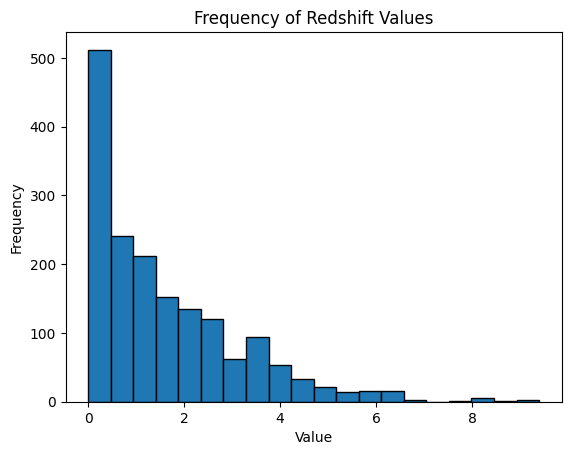

In [ ]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(numbers, bins=20, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Redshift Values')

# Display the histogram
plt.show()

In [ ]:
redshift_table.to_csv('all_redshifts.csv')

In [ ]:
grb_list = []
header = ['Circular Number', 'Text', 'GRB Name', 'Confidence Score']

for index, row in tqdm(redshift_table.iterrows(), total=redshift_table.shape[0]):
  circ_num = row["Circular Number"]
  answer = ''
  score = ''
  if row["Redshift Value"] != '':
    context = row["Text"]
    question = 'what is the grb name?'
    preds = question_answerer(question=question, context=context, handle_impossible_answer=True)
    answer = preds["answer"]
    score = preds["score"]
  grb_list.append([circ_num, context, answer, score])

grb_table = pd.DataFrame(grb_list, columns=header)

  0%|          | 0/2259 [00:00<?, ?it/s]

In [ ]:
grb_table.to_csv('all_grbs.csv')

In [ ]:
redshift_table

,Unnamed: 0,Circular Number,Text,Redshift Value,Confidence Score
0,0,11638,title: gcn circular\nnumber: 11638\nsubject...,z=2.22.,0.999888
1,1,31107,title: gcn circular\nnumber: 31107\nsubject...,\n0.862.,0.999204
2,2,7808,title: gcn circular\nnumber: 7808\nsubject:...,2.69,0.999880
3,3,10835,title: gcn circular\nnumber: 10835\nsubject...,NaN,0.304732
4,4,8889,title: gcn circular\nnumber: 8889\nsubject:...,4.6,0.999860
...,...,...,...,...,...
2254,2254,1000011,title: gcn circular\nnumber: 1000011\nsubje...,z < 1.4,0.919623
2255,2255,1000001,title: gcn circular\nnumber: 1000001\nsubje...,0.73 < z < 2.91.,0.999384
2256,2256,1000002,title: gcn circular\nnumber: 1000002\nsubje...,1.4 < z < 3.456.,0.994580
2257,2257,1000003,title: gcn circular\nnumber: 1000003\nsubje...,0.5 < z < 4.5.,0.999414


In [ ]:
grb_table

,Circular Number,Text,GRB Name,Confidence Score
0,11638,title: gcn circular\nnumber: 11638\nsubject...,110205a:,0.999967
1,31107,title: gcn circular\nnumber: 31107\nsubject...,211023b:,0.999971
2,7808,title: gcn circular\nnumber: 7808\nsubject:...,080603b:,0.999938
3,10835,title: gcn circular\nnumber: 10835\nsubject...,100606a:,0.999972
4,8889,title: gcn circular\nnumber: 8889\nsubject:...,090205:,0.999960
...,...,...,...,...
2254,1000011,title: gcn circular\nnumber: 1000011\nsubje...,150424a:,0.999962
2255,1000001,title: gcn circular\nnumber: 1000001\nsubje...,grb090814a:,0.999954
2256,1000002,title: gcn circular\nnumber: 1000002\nsubje...,grb090814a:,0.999953
2257,1000003,title: gcn circular\nnumber: 1000003\nsubje...,grb090814a:,0.999951


In [ ]:
redshift_table["GRB Name"] = grb_table["GRB Name"].values

In [ ]:
redshift_table.tail(12)

,Unnamed: 0,Circular Number,Text,Redshift Value,Confidence Score,GRB Name
2247,2247,1000004,title: gcn circular\nnumber: 1000004\nsubje...,1.4 < z < 2.6,0.428039,grb110726a:
2248,2248,1000005,title: gcn circular\nnumber: 1000005\nsubje...,0.98 < z < 3.55,0.960736,grb110726a:
2249,2249,1000006,title: gcn circular\nnumber: 1000006\nsubje...,1.345 < z < 2.9,0.839614,grb110726a:
2250,2250,1000007,title: gcn circular\nnumber: 1000007\nsubje...,\nz < ~3.21.,0.998257,160703a:
2251,2251,1000008,title: gcn circular\nnumber: 1000008\nsubje...,\nz > 3.56.,0.996436,160703a:
2252,2252,1000009,title: gcn circular\nnumber: 1000009\nsubje...,\nz > ~2.,0.993429,160703a:
2253,2253,1000012,title: gcn circular\nnumber: 1000012\nsubje...,z < 4.,0.967167,181213a:
2254,2254,1000011,title: gcn circular\nnumber: 1000011\nsubje...,z < 1.4,0.919623,150424a:
2255,2255,1000001,title: gcn circular\nnumber: 1000001\nsubje...,0.73 < z < 2.91.,0.999384,grb090814a:
2256,2256,1000002,title: gcn circular\nnumber: 1000002\nsubje...,1.4 < z < 3.456.,0.994580,grb090814a:


In [ ]:
redshift_table.drop(redshift_table.tail(12).index, inplace = True)

In [ ]:
grb_set = set()
x=[]
for index, row in redshift_table.iterrows():
  if row["GRB Name"] in grb_set:
    continue
  grb_set.add(row["GRB Name"])
  x.append(row["Redshift Value"])

print(x)

[' z=2.22.', '\n0.862.', ' 2.69', nan, ' 4.6', ' 3.87.', ' z~0.12', ' 0.7055', ' z=4.042', ' z=5.913,', ' z=5.6', ' z=1.17', '\nz=4.5^+0.3_-0.2', ' 1.4,', ' z=0.117,', ' a_z=0.049', ' z<3.5.', '\nz=0.217', ' 1.3', ' 3.2', ' 0.151', ' =0.604.', ' 1.2.', ' 0.96', nan, ' 3.3437', nan, '\n0.151', ' ~1.3.', ' 6.5', '\n0.228.', ' 2.04.', ' 0.0013.', ' z=0.81', ' z=1.105', ' 0.632', ' 3.8', nan, ' 0.8230', ' 2.272.', ' 2.737', nan, ' 1.256', nan, ' z=2.321,2.327', ' 1.409,', '\n0.889,', ' z <= 3,', ' 4.618', ' 0.0785', '\nz=9.4', ' z=3.796,', ' 2.01,', ' z=0.593', ' 3.1', ' 2.42', nan, '\nz=3.626', nan, ' 2.330,', ' 1.20.', ' 3.4', ' 0.49', ' z=1.381', ' 2.452', nan, ' 0.55.', ' 1.608', ' (4.5<z<6.5)', ' 3.65.', nan, ' z~6-6.5', '\nz=0.2411.', ' 3.1', ' z=1.949.', nan, ' 0.6235', '\nz=1.004+-0.002.', ' 2.3.', ' z=21.35+/-0.30', ' z<4.3,', ' 1.394.', nan, ' 2.02', nan, ' z=2.823,', ' 0.876', nan, ' z=1.968.', ' 1.4', ' z=2.0', ' 0.886,', ' z=3.685.', nan, ' < 2.3', ' z=1.937', ' 0.6898', nan, 

In [ ]:
x = [num for num in x if type(num) == str]

In [ ]:
# Extract numbers from the lines
numbers = [float(num) for line in x if '>' not in line and '<' not in line for num in re.findall(r'\d+\.\d+', line)]

# Print the extracted numbers
print(numbers)

[2.22, 0.862, 2.69, 4.6, 3.87, 0.12, 0.7055, 4.042, 5.913, 5.6, 1.17, 4.5, 0.3, 0.2, 1.4, 0.117, 0.049, 0.217, 1.3, 3.2, 0.151, 0.604, 1.2, 0.96, 3.3437, 0.151, 1.3, 6.5, 0.228, 2.04, 0.0013, 0.81, 1.105, 0.632, 3.8, 0.823, 2.272, 2.737, 1.256, 2.321, 2.327, 1.409, 0.889, 4.618, 0.0785, 9.4, 3.796, 2.01, 0.593, 3.1, 2.42, 3.626, 2.33, 1.2, 3.4, 0.49, 1.381, 2.452, 0.55, 1.608, 3.65, 6.5, 0.2411, 3.1, 1.949, 0.6235, 1.004, 0.002, 2.3, 21.35, 0.3, 1.394, 2.02, 2.823, 0.876, 1.968, 1.4, 2.0, 0.886, 3.685, 1.937, 0.6898, 0.414, 1.547, 3.568, 0.093, 1.314, 3.5, 3.139, 0.003, 1.6, 0.755, 0.97, 0.859, 1.71, 5.283, 3.3, 0.283, 0.58, 0.7, 1.0, 1.73, 3.1516, 1.262, 0.313, 0.08, 5.3, 9.0, 2.02, 2.48, 0.7, 1.968, 0.145, 0.716, 1.083, 0.422, 0.102, 3.503, 3.8, 0.41, 2.43, 0.947, 1.105, 0.36, 0.555, 0.1, 0.3, 0.1475, 1.717, 0.568, 1.06, 0.059, 3.29, 1.092, 3.35, 8.5, 3.036, 3.2, 2.612, 2.512, 0.793, 2.78, 1.1, 1.736, 6.318, 2.7, 4.0, 1.44, 2.609, 1.4768, 3.3, 0.256, 3.54, 4.7, 2.71, 3.5, 2.2, 1.0, 0

In [ ]:
numbers = [num for num in numbers if num<=10]

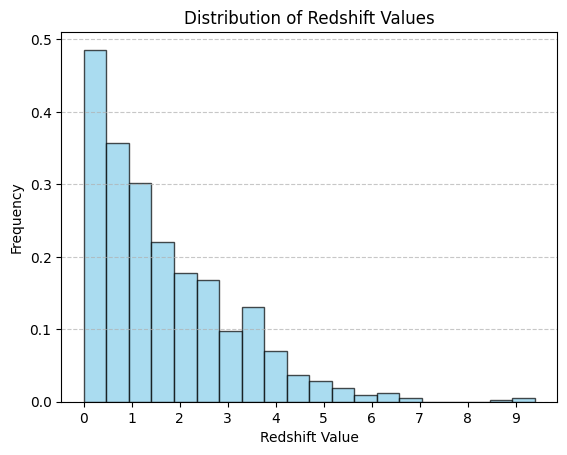

In [ ]:
import matplotlib.pyplot as plt

plt.hist(numbers, bins=20, edgecolor='black', alpha=0.7, color='skyblue', density=True)

# Adding labels and title
plt.xlabel('Redshift Value')
plt.ylabel('Frequency')
plt.title('Distribution of Redshift Values')

plt.xticks(range(0, int(max(numbers)) + 1))

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the histogram
plt.show()

#Step 6: Error Analysis

In [ ]:
'''
Now we shall do some investigations into the false predictions of our model
'''

table_list = []
circular_num_format = re.compile('number\:  (\d+)')
header=['Circular Number', 'True Redshift', 'Predicted Redshift', 'Predicted GRB', 'Predicted Telescope']
count=0

for test in dataset["test"]:
  if test["question"] != 'what is the redshift value?':
    continue
  circ_num_match = circular_num_format.search(test["context"])
  circ_num = circ_num_match.group(1)
  preds = question_answerer(question='what is the redshift value?', context=test["context"], handle_impossible_answer=True)
  preds_1 = question_answerer(question='what is the grb name?', context=test["context"], handle_impossible_answer=True)
  preds_2 = question_answerer(question='what is the name of the telescope used?', context=test["context"], handle_impossible_answer=True)
  table_list.append([circ_num, test["answer"], preds["answer"], preds_1["answer"], preds_2["answer"]])
  count = count+1
  if count==8:
    break

table_list = pd.DataFrame(table_list, columns=header)

In [ ]:
table_list

,Circular Number,True Redshift,Predicted Redshift,Predicted GRB,Predicted Telescope
0,4701,4.048,4.048,060206:,lick
1,10439,4.5,4.5).,100219a:,mpi/eso
2,9761,2.737,2.737,090809,vlt
3,32079,5.6,5.6.,220521a:,not
4,1000010,z < 4.32,z < 4.32,060708:,vlt
5,3924,6.10,6.10,050904:,"vlt-ut1,"
6,10752,4.772,4.772.,100513a:,gemini north
7,13507,0.9586,0.9586.,120722a:,vlt/x-shooter


In [ ]:
# Drop row at index 4
table_list.drop(4, inplace=True)

# Resetting index after dropping the row
table_list.reset_index(drop=True, inplace=True)

In [ ]:
table_list

,Circular Number,True Redshift,Predicted Redshift,Predicted GRB,Predicted Telescope
0,4701,4.048,4.048,060206:,lick
1,10439,4.5,4.5).,100219a:,mpi/eso
2,9761,2.737,2.737,090809,vlt
3,32079,5.6,5.6.,220521a:,not
4,3924,6.10,6.10,050904:,"vlt-ut1,"
5,10752,4.772,4.772.,100513a:,gemini north
6,13507,0.9586,0.9586.,120722a:,vlt/x-shooter


In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Define the Excel writer
excel_file = 'output.xlsx'
excel_writer = pd.ExcelWriter(excel_file, engine='xlsxwriter')

# Convert the DataFrame to an Excel table
table_list.to_excel(excel_writer, sheet_name='Sheet1', index=False, startrow=1, header=False)

# Get the xlsxwriter workbook and worksheet objects
workbook = excel_writer.book
worksheet = excel_writer.sheets['Sheet1']

# Define a table style
table_format = workbook.add_format({'border': 1, 'align': 'center', 'valign': 'vcenter'})

# Set the column width and format for the table
for i, col in enumerate(table_list.columns):
    column_len = max(table_list[col].astype(str).apply(len).max(), len(col))
    worksheet.set_column(i, i, column_len)
    worksheet.write(0, i, col, table_format)

# Make the table
worksheet.add_table(0, 0, table_list.shape[0], table_list.shape[1] - 1, {'columns': [{'header': col} for col in table_list.columns]})

# Save the Excel file
excel_writer.save()
print(f'Excel file "{excel_file}" created successfully.')

Excel file "output.xlsx" created successfully.


<ipython-input-88-839a204fb75a>:25: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()


In [ ]:
# Plot the DataFrame as a table
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  # Hide axis
ax.table(cellText=table_list.values, colLabels=table_list.columns, loc='center', cellLoc='center')

# Save the plot as a PNG image
png_file = 'output_table.png'
plt.savefig(png_file, bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.close()

print(f'PNG image "{png_file}" created successfully.')

PNG image "output_table_pretty.png" created successfully.
